<h1>Energy Price Forecasting Setup Script</h1>

<h2>Project Setup using Notebook</h2>

<h3> <ins>Pre-requisites:</ins></h3>

1. <b>You have conda/miniconda installed. If not, please install following the [doc](https://docs.conda.io/projects/miniconda/en/latest/)</b>
2. <b>Role with access to install NativeApps from marketplace like ACCOUNTADMIN</b>
3. <b>Any environment to run notebooks like Jupyterlab, etc.,</b>


<h2> <ins>Process Flow</ins></h2>

<p> Before we start building the app, the high level flow of the steps is as below</p>

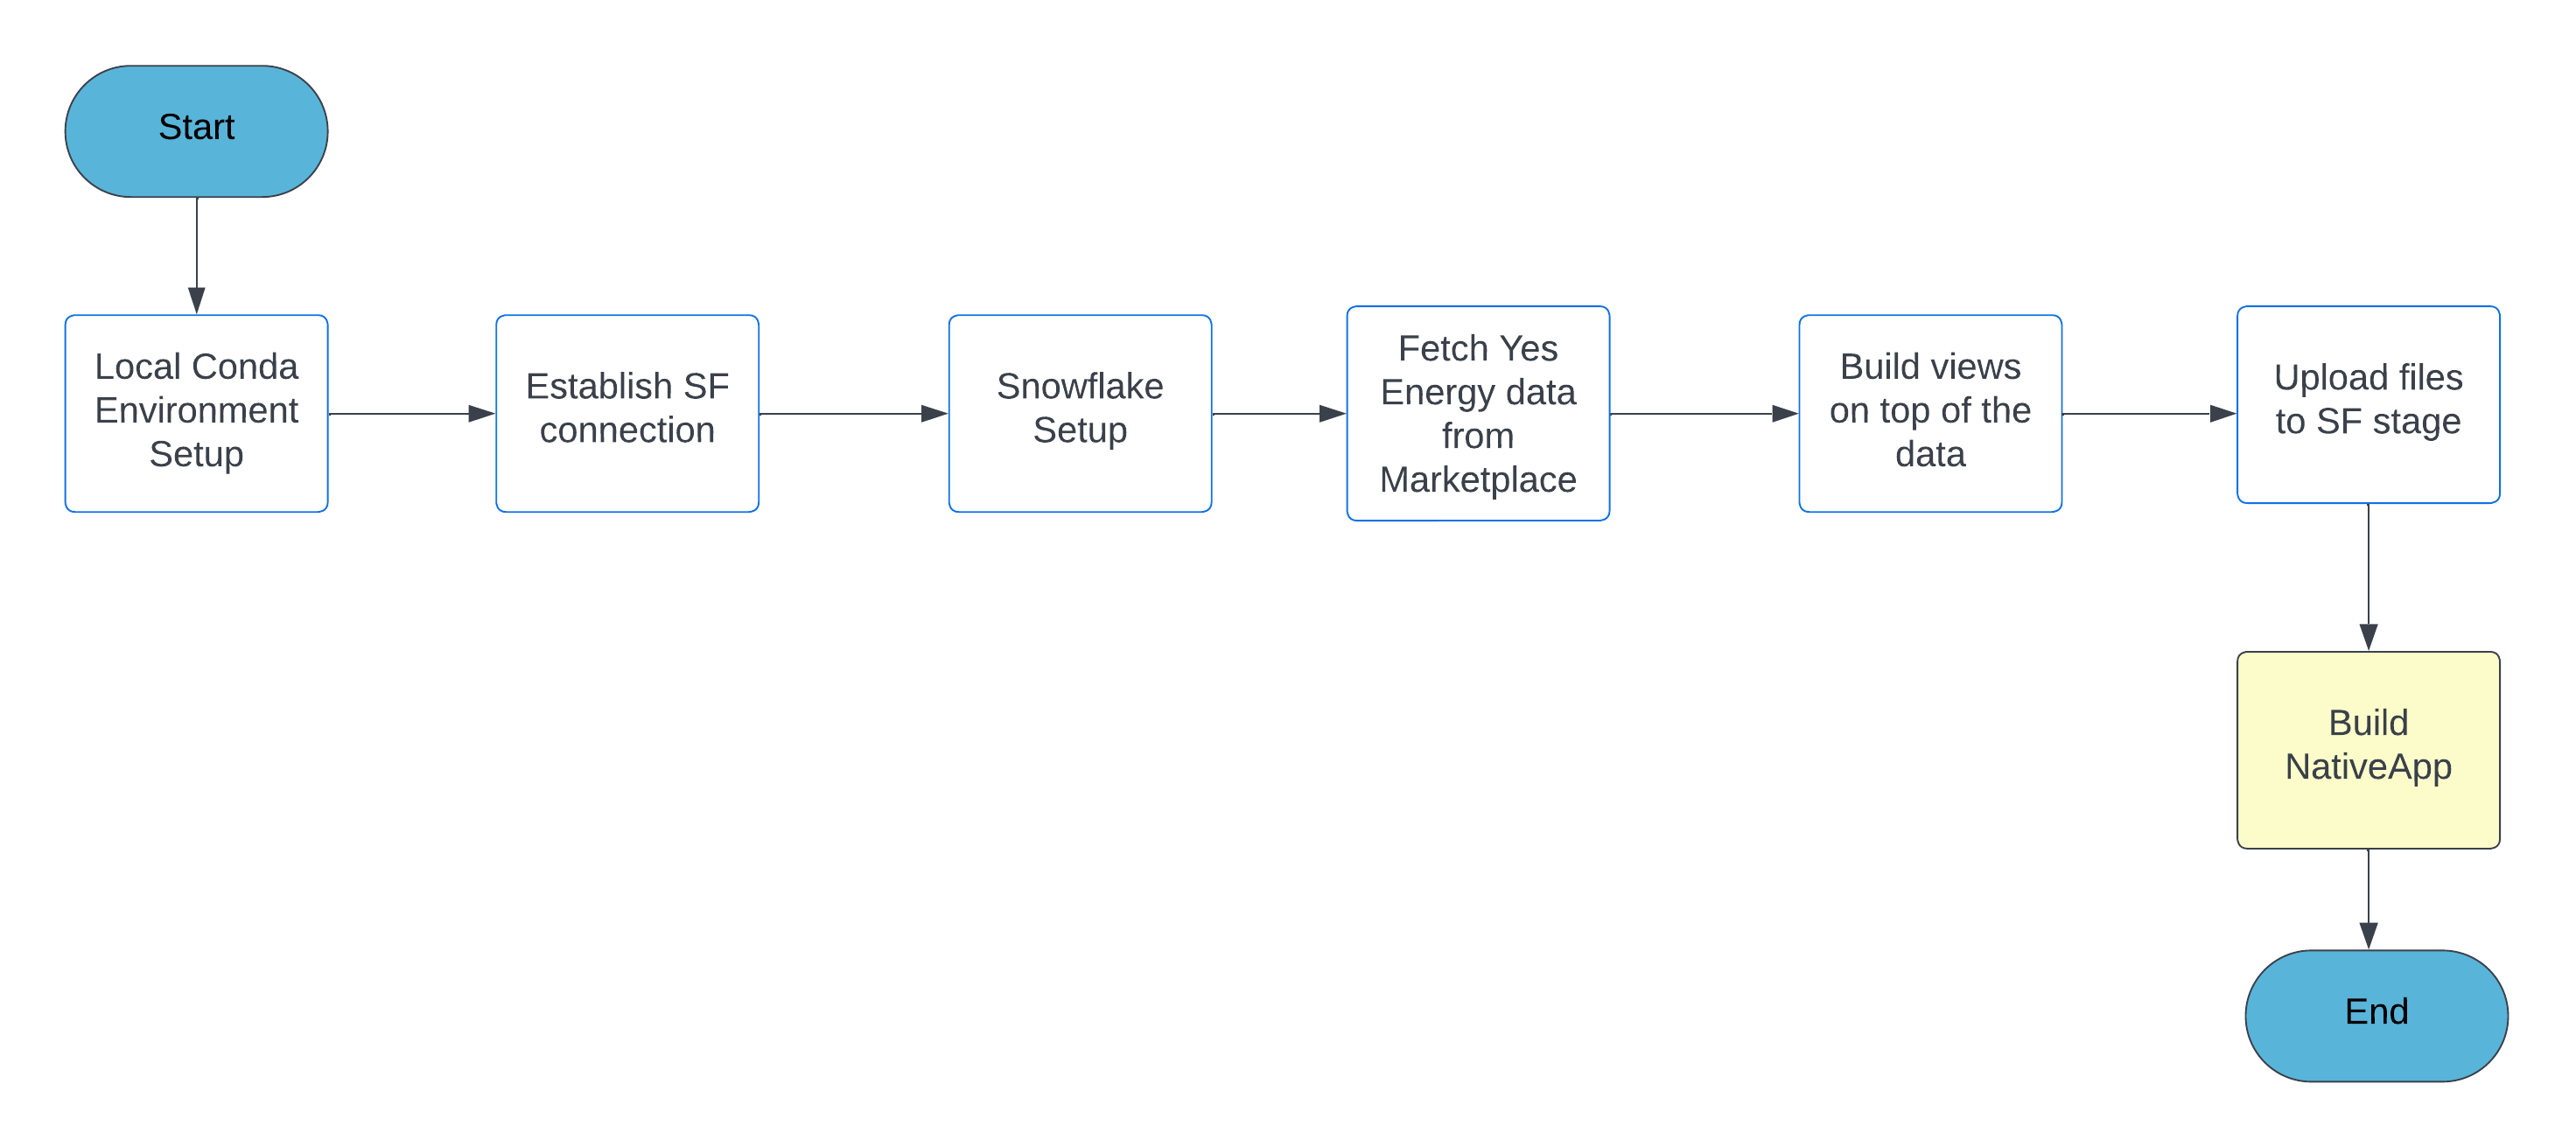

<h2> <ins>Local Environment Setup</ins></h2>

In [68]:
%%capture
#### We have disabled the results of this block using %%capture but feel free to uncomment to debug

! conda create --name energy_forecasting python=3.8 -y
! conda install -c anaconda ipykernel -y
! python -m ipykernel install --user --name=energy_forecasting

<h3> <ins>Kernet Setup and Package Installation</ins></h3>
<h4>PLEASE CHANGE THE DEFAULT KERNEL TO <span style="color:blue">energy_forecasting </span>NOW</h4>

In [69]:
#### To ensure the environment is created
! conda env list

# conda environments:
#
base                  *  /Users/nthomas/anaconda3
campaign_intelligence     /Users/nthomas/anaconda3/envs/campaign_intelligence
cirruslink               /Users/nthomas/anaconda3/envs/cirruslink
cirruslink_naveen        /Users/nthomas/anaconda3/envs/cirruslink_naveen
dbt_base                 /Users/nthomas/anaconda3/envs/dbt_base
energy-forecast          /Users/nthomas/anaconda3/envs/energy-forecast
energy_forecasting       /Users/nthomas/anaconda3/envs/energy_forecasting
fsi_portfolio            /Users/nthomas/anaconda3/envs/fsi_portfolio
fsi_quant_research       /Users/nthomas/anaconda3/envs/fsi_quant_research
pricing_trans            /Users/nthomas/anaconda3/envs/pricing_trans
pysnowpark_dicom         /Users/nthomas/anaconda3/envs/pysnowpark_dicom
snowvation               /Users/nthomas/anaconda3/envs/snowvation



<h4>Package Installation</h4>

We have disabled the results of this block using %%capture but feel free to uncomment to debug

In [70]:
%%capture
pip install -r requirements.txt

<h4>PLEASE <span style="color:blue">RESTART KERNEL energy_forecasting </span>NOW</h4>

In [71]:
#### This is just to ensure all the packages in requirements.txt is install in the current environment (we are checking only Snowpark package here)
! conda list ^snow

# packages in environment at /Users/nthomas/anaconda3:
#
# Name                    Version                   Build  Channel
snowballstemmer           2.2.0              pyhd3eb1b0_0  
snowflake-connector-python 3.6.0                    pypi_0    pypi
snowflake-snowpark-python 1.11.1                   pypi_0    pypi


<h2> <ins>Establish SF connection</ins></h2>

<h3> <ins>Configuration for the App</ins></h3>

<h4> Please ensure the <span style="color:blue">connection_config.json</span> has the creds to develop the solution </h4>

<p> <span style="color:brown">Ensure to provide an existing database name, schema name, warehouse name that you have access to in the connection_config.json, we will create our own DB in the demo as we proceed. This is just to ensure the connection works.<span style="color:brown"></p>

<h5> <span style="color:red">If the account locator has a dot seperator, in the connection_config.json please replace the dot operator with hyphen. e.g., if the account locator is MHUVYYY.SY816XX, the account in json should be MHUVYYY-SY816XX<span style="color:red"></h5>

<b>
{
    "account": "account_locator"
    ,"user": "USER_NAME"
    ,"password": "PASSWORD"
    ,"database": "DATABASE"
    ,"schema": "SCHEMA"
    ,"warehouse": "WAREHOUSE_NAME"
    ,"role":"ROLE_NAME"
}</b>

<h5><ins>Authentication</ins></h5>

In [72]:
# Snowpark initialization 
import snowflake.snowpark
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
from snowflake.snowpark import version as v
import json
from snowflake.snowpark.functions import *

import pandas as pd
import numpy as np
import datetime
import io

snow_conn_flpath = 'connection_config.json'

with open(snow_conn_flpath) as conn_f:
    snow_conn_info = json.load(conn_f)

sp_session = Session.builder.configs(snow_conn_info).create()
sp_session.use_warehouse('COMPUTE_WH')
print(sp_session.sql('select current_account(), current_warehouse(), current_database(), current_schema()').collect())

sp_session.add_packages('snowflake-snowpark-python', 'pandas', 'numpy', 'pydeck')


[Row(CURRENT_ACCOUNT()='UQ30553', CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='SNOWFLAKE', CURRENT_SCHEMA()='INFORMATION_SCHEMA')]


The version of package 'pydeck' in the local environment is 0.8.1b0, which does not fit the criteria for the requirement 'pydeck'. Your UDF might not work when the package version is different between the server and your local environment.


In [73]:
app_config_flpath = 'app_config.json'

with open(app_config_flpath) as app_f:
    app_config = json.load(app_f)

<h2> <ins>Snowflake Setup</ins></h2>

In [74]:
sp_session.sql("create or replace database {0} comment = 'used for demonstrating Energy Price Forecasting demo';".format(app_config['database'])).collect()
sp_session.sql("create or replace schema {0}.{1};".format(app_config['database'], app_config['schema'])).collect()
sp_session.sql("use schema {0}.{1};".format(app_config['database'], app_config['schema'])).collect()
sp_session.sql("create or replace stage lib_stg directory = ( enable = true ) comment = 'used for holding udfs and procs.';").collect()
sp_session.sql("create or replace stage data_stg comment = 'used for holding data.';").collect()
sp_session.sql("create or replace stage scripts_stg comment = 'used for holding scripts.';").collect()
sp_session.sql("create or replace stage ML_MODELS comment = 'used for holding models.';").collect()
sp_session.sql("create or replace stage ML_SPIKE_MODELS comment = 'used for holding spike models.';").collect()



[Row(status='Stage area ML_SPIKE_MODELS successfully created.')]

<h2> <ins> Yes Energy Sample Data Fetch from Marketplace:</ins> </h2> 

1. Please navigate to the Marketplace tab

2. Ensure you are in the "ACCOUNTADMIN" role

3. Type in "Yes Energy" in the search box

4. Select the provider "Yes Energy"

![](./Search_data_energy_price_forecasting.png)

5. Select the "Yes Energy - Sample Data" 

6. Click "Get"

7. Click "Get" again on the next screen

8. Click "Done" on the final screen.

![](./Get_data_energy_price_forecasting.png)

<h2> <ins> Data Dictionary</ins> </h2> 

For more detail on why the following features were selected, please read the original price spike forecasting tutorial on Myst AI's documentation page: https://docs.myst.ai/docs/create-a-price-spike-forecast-model

**LOAD_FORECAST	10000712973**	Load forecast, ERCOT-wide

**LOAD_FORECAST	10002211347**	Load forecast, Far West weather zone

**LOAD_FORECAST	10002211349**	Load forecast, North Central weather zone

**LOAD_FORECAST	10002211348**	Load forecast, North weather zone

**LOAD_FORECAST	10002211351**	Load forecast, Southern weather zone

**WIND_COPHSL	10004189442**	Wind production forecast, ERCOT-wide

**WIND_COPHSL	10004189446**	Wind production forecast, Coastal generation region

**WIND_COPHSL	10004189445**	Wind production forecast, Panhandle generation region

**WIND_COPHSL	10004189447**	Wind production forecast, Southern generation region

**WIND_COPHSL	10004189450**	Wind production forecast, West generation region

**SOLAR_COPHSL	10000712973**	ERCOT-wide solar production forecast

**HSL_DA	10000712973**	ERCOT-wide high sustainable load from all generating resources in the DAM run

**RT_ON_CAP	10000756298**	ERCOT-wide system reserves, the amount of capacity available in addition to the load that is currently being served

**GEN_RESOURCE	10000756298**	ERCOT-wide forecast of the generation capacity in ERCOT across all power generation types

**SYSTEM_LAMBDA	10000756298**	Energy component of the ERCOT-wide real-time (RT) locational marginal price

**SYSTEM_LAMBDA_DA	10000756298**	Energy component of the ERCOT-wide day-ahead (DA) locational marginal price

<h2> <ins> Build Data View from Yes Energy datasets</ins> </h2> 

In [75]:
from tqdm import tqdm
def fetch_yes_energy_data(selecteddf, database_name, app_db, app_sch):
    """
    This is used to fetch right timeframe of YES ENERGY data that is needed for training and building the forecasting model. 
    The output of this function is ML_DATA table and ML_DATA_SPIKE table.
    """
    sp_session.use_schema("{0}.{1}".format(app_db, app_sch))
    datas=[]
    for i in tqdm(range(selecteddf.shape[0])):
        row=selecteddf.iloc[i]
        query="select * from {3}.YES_ENERGY_SAMPLE.{0} \
                        where objectid= '{1}' and datatypeid= '{2}'".format(row['view'], 
                                                                                row['objectid'], 
                                                                                row['datatypeid'], 
                                                                                database_name)
                                                                                
        data=sp_session.sql(query).to_pandas()
        temp1=[str(i)[:-6] for i in data.DATETIME] #get hourly data or estimate hourly data
        data.DATETIME=pd.to_datetime(temp1, format='%Y-%m-%d %H')
        data['DATATYPE']=list(np.repeat(row.seriesname,len(temp1)))
        datas+=[data]
        
    #combine list of data to one dataframe
    df=pd.concat(datas, axis=0)

    #reverse melt process
    df['COLUMN']=[k+'_'+str(v) for k,v in zip(df.DATATYPE,df.OBJECTID)]

    #Cleaning up the dataset
    df=df.drop(['DATATYPE','OBJECTID','TIMEZONE'],axis=1)
    df=df.drop_duplicates(['DATETIME','COLUMN'])

    df=df.pivot(index='DATETIME',columns='COLUMN',values='VALUE' )

    #Create Shifts in Datasets
    #Shifting RT Price today backwards 24 rows in order to calculate the RT price of tomorrow.
    df['RTPRICE_TOMM']=df['SYSTEM_LAMBDA_10000756298'].shift(-24)
    
    df['SYSTEM_LAMBDA_10000756298']=df['SYSTEM_LAMBDA_10000756298'].shift(24)

    df = df.dropna()     

    #clip target variable like tutorial
    df['RTPRICE_TOMM']=[500 if i>500 else i for i in df['RTPRICE_TOMM']]
    df['DATETIME']=[str(i) for i in df.index]
    sp_session.use_schema("{0}.{1}".format(app_db, app_sch))
    sp_session.write_pandas(df, 'ML_DATA', database=app_db, schema=app_sch, auto_create_table=True, overwrite=True)

    # Price Spike Data
    #combine list of data to one dataframe
    df_spike=pd.concat(datas, axis=0)

    #reverse melt process
    df_spike['COLUMN']=[k+'_'+str(v) for k,v in zip(df_spike.DATATYPE,df_spike.OBJECTID)]

    df_spike=df_spike.drop(['DATATYPE','OBJECTID','TIMEZONE'],axis=1)
    df_spike=df_spike.drop_duplicates(['DATETIME','COLUMN'])

    df_spike=df_spike.pivot(index='DATETIME',columns='COLUMN',values='VALUE' )

    #Create Shifts in Datasets
    #Shifting RT Price today backwards 24 rows in order to calculate the RT price of tomorrow.
    df_spike['RTPRICE_TOMM']=df_spike['SYSTEM_LAMBDA_10000756298'].shift(-24)
    df_spike['RTPRICE_TOMM']=df_spike['SYSTEM_LAMBDA_10000756298']>50
    #Shifting the RT Price today forward 24 rows in order to calculate RT price yesterday
    df_spike['SYSTEM_LAMBDA_10000756298']=df_spike['SYSTEM_LAMBDA_10000756298'].shift(24)

    df_spike = df_spike.dropna()

    df_spike['DATETIME']=[str(i) for i in df_spike.index]
    sp_session.write_pandas(df_spike, 'ML_DATA_SPIKE', database=app_db, schema=app_sch, auto_create_table=True, overwrite=True)
    return df

In [76]:
view=['TS_FORECAST_SAMPLE','TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE', 'TS_FORECAST_SAMPLE','TS_FORECAST_SAMPLE','TS_FORECAST_SAMPLE','TS_LOAD_SAMPLE','TS_ANCILLARY_SAMPLE','TS_FORECAST_SAMPLE','TS_ANCILLARY_SAMPLE','TS_ANCILLARY_SAMPLE',]
objectid=[10000712973,10002211347,10002211349,10002211348,10002211351,10004189442,10004189446,10004189445,10004189447,10004189450,10000712973,10000712973,10000756298,10000756298,10000756298,10000756298,]
datatypeid= [19060,138,138,138,138,9139,9139,9139,9139,9139,661,9641,9821,19,9822,130,]
seriesname=['LOAD_FORECAST','LOAD_FORECAST','LOAD_FORECAST','LOAD_FORECAST','LOAD_FORECAST','WIND_COPHSL','WIND_COPHSL','WIND_COPHSL','WIND_COPHSL','WIND_COPHSL','SOLAR_COPHSL','HSL_DA','RT_ON_CAP','GEN_RESOURCE','SYSTEM_LAMBDA','SYSTEM_LAMBDA_DA']
data_query=pd.DataFrame({'view': view, 'objectid': objectid, 'datatypeid': datatypeid, 'seriesname': seriesname})
data_query

,view,objectid,datatypeid,seriesname
0,TS_FORECAST_SAMPLE,10000712973,19060,LOAD_FORECAST
1,TS_FORECAST_SAMPLE,10002211347,138,LOAD_FORECAST
2,TS_FORECAST_SAMPLE,10002211349,138,LOAD_FORECAST
3,TS_FORECAST_SAMPLE,10002211348,138,LOAD_FORECAST
4,TS_FORECAST_SAMPLE,10002211351,138,LOAD_FORECAST
5,TS_FORECAST_SAMPLE,10004189442,9139,WIND_COPHSL
6,TS_FORECAST_SAMPLE,10004189446,9139,WIND_COPHSL
7,TS_FORECAST_SAMPLE,10004189445,9139,WIND_COPHSL
8,TS_FORECAST_SAMPLE,10004189447,9139,WIND_COPHSL
9,TS_FORECAST_SAMPLE,10004189450,9139,WIND_COPHSL


In [77]:
fetch_yes_energy_data(data_query, 'YES_ENERGY__SAMPLE_DATA',app_config['database'], app_config['schema'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]
/Users/nthomas/anaconda3/lib/python3.11/site-packages/snowflake/snowpark/session.py:1951: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(
/Users/nthomas/anaconda3/lib/python3.11/site-packages/snowflake/snowpark/session.py:1951: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, 

COLUMN,GEN_RESOURCE_10000756298,HSL_DA_10000712973,LOAD_FORECAST_10000712973,LOAD_FORECAST_10002211347,LOAD_FORECAST_10002211348,LOAD_FORECAST_10002211349,LOAD_FORECAST_10002211351,RT_ON_CAP_10000756298,SOLAR_COPHSL_10000712973,SYSTEM_LAMBDA_10000756298,SYSTEM_LAMBDA_DA_10000756298,WIND_COPHSL_10004189442,WIND_COPHSL_10004189445,WIND_COPHSL_10004189446,WIND_COPHSL_10004189447,WIND_COPHSL_10004189450,RTPRICE_TOMM,DATETIME
DATETIME,,,,,,,,,,,,,,,,,,
2021-11-11 00:00:00,42818.0,43859.0,36921.912231,4019.5801,800.001,9837.4004,3109.78,10108.620000,0.0,-1.886900,30.843000,14036.5,1713.2,2289.3,2322.4,6123.9,1.869700,2021-11-11 00:00:00
2021-11-11 01:00:00,43177.6,43738.0,34839.358337,3946.78,791.991,9226.6104,2871.5,10866.820000,0.0,-3.666900,28.236400,13319.9,1897.1,2057.3,2085.4,5583.6,13.593600,2021-11-11 01:00:00
2021-11-11 02:00:00,43216.9,43012.0,33835.816223,3865.9099,769.237,8966.4004,2745.29,11882.810000,0.0,-2.524600,26.075500,13366.4,1733.0,1878.3,1801.3,6414.5,13.478100,2021-11-11 02:00:00
2021-11-11 03:00:00,42495.6,42170.0,33114.539428,3741.45,747.62,8692.1201,2652.53,10712.420000,0.0,-2.435200,27.062500,12615.2,1280.6,1560.3,1453.8,6869.2,13.303500,2021-11-11 03:00:00
2021-11-11 04:00:00,41961.5,40943.0,32799.628234,3677.1001,741.409,8576.2598,2568.6899,8574.620000,0.0,12.696800,27.445400,12050.7,888.4,1237.4,1343.0,7162.2,16.673700,2021-11-11 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 19:00:00,47613.7,49121.0,44832.669799,5661.1899,1169.97,12195.5996,3601.1899,7864.250000,0.0,39.693900,68.989000,4283.1,520.7,2062.3,818.2,591.4,72.473500,2023-11-12 19:00:00
2023-11-12 20:00:00,48033.0,49614.0,45237.119628,5870.2598,1221.55,12310.9004,3532.4399,7956.560000,0.0,42.717600,49.970600,4699.0,750.0,2376.5,712.4,586.1,40.076900,2023-11-12 20:00:00
2023-11-12 21:00:00,48168.9,49752.0,45044.139526,6164.6099,1309.48,12039.7002,3452.6899,8023.200000,0.0,62.830100,41.101200,5752.0,988.3,2932.0,768.5,659.7,45.051100,2023-11-12 21:00:00


In [78]:
sp_session.sql("CREATE OR REPLACE VIEW {0}.{1}.ML_DATA_VW as SELECT * FROM {0}.{1}.ML_DATA;".format(app_config['database'], app_config['schema'])).collect()
sp_session.sql("CREATE OR REPLACE VIEW {0}.{1}.ML_DATA_SPIKE_VW as SELECT * FROM {0}.{1}.ML_DATA_SPIKE;".format(app_config['database'], app_config['schema'])).collect()

[Row(status='View ML_DATA_SPIKE_VW successfully created.')]

<h2> <ins> Upload NativeApp files to Stage:</ins> </h2> 

In [95]:
def create_nativeapp_pkg(_sp_session, _config, app_name, view_list, role_name, database, schema):
    """ Create a nativeapp package and update native app codebase as per the views shared. 
    """  
    _sp_session.sql("use role {0};".format(role_name)).collect()

    _sp_session.sql("CREATE OR REPLACE DATABASE {0};".format(app_name+'_CODE')).collect()
    _sp_session.sql("USE DATABASE {0};".format(app_name+'_CODE')).collect()
    _sp_session.sql("CREATE OR REPLACE SCHEMA {0};".format('CORE')).collect()
    _sp_session.sql("CREATE OR REPLACE STAGE {0}.{1}.{2} DIRECTORY = (ENABLE = TRUE) FILE_FORMAT = (TYPE = 'CSV' FIELD_DELIMITER = '|' SKIP_HEADER = 1);".format(app_name+'_CODE','CORE',app_name+'_CODE_STG')).collect()
    _sp_session.sql("DROP APPLICATION PACKAGE IF EXISTS {0}".format(app_name+'_PKG')).collect()
    _sp_session.sql("CREATE APPLICATION PACKAGE {0};".format(app_name+'_PKG')).collect()
    _sp_session.sql("USE {0};".format(app_name+'_PKG')).collect()
    _sp_session.sql("CREATE OR REPLACE SCHEMA {0};".format('SHARED_CONTENT')).collect()
    _sp_session.sql("GRANT USAGE ON SCHEMA {0} TO SHARE IN APPLICATION PACKAGE {1};".format('SHARED_CONTENT', app_name+'_PKG')).collect()
    _sp_session.sql("USE SCHEMA {0}.{1};".format(app_name+'_PKG', 'SHARED_CONTENT')).collect()

    with open("./energy_price_forecasting_nativeapp/scripts/setup.sql", "a") as sqlscript:
        for views in view_list:
            _sp_session.sql("GRANT REFERENCE_USAGE ON DATABASE {0} TO SHARE IN APPLICATION PACKAGE {1};".format(database, app_name+'_PKG')).collect()
            _sp_session.sql("CREATE OR REPLACE SECURE VIEW SHARED_CONTENT.{2} AS SELECT * FROM {0}.{1}.{2};".format(database, schema,views)).collect()
            _sp_session.sql("ALTER VIEW SHARED_CONTENT.{0} SET CHANGE_TRACKING = True;".format(views)).collect()
            _sp_session.sql("GRANT SELECT ON VIEW SHARED_CONTENT.{0} TO SHARE IN APPLICATION PACKAGE {1};".format(views, app_name+'_PKG')).collect()
            sqlscript.writelines("\n")
            sqlscript.writelines("CREATE OR REPLACE SECURE VIEW CRM.{0} AS SELECT * FROM SHARED_CONTENT.{0};\n".format(views))
            sqlscript.writelines("GRANT SELECT ON VIEW CRM.{0} TO APPLICATION ROLE APP_PUBLIC;\n".format(views))
    return 'Success'

In [96]:
import os
def upload_nativeappfiles_to_stage(p_sflk_session ,p_local_dir ,p_db ,p_sch ,p_stage, role_name ):
    """ Used for uploading third party libraries from a local directory to an stage. 
        :param p_sflk_session: The snowflake session
        :param p_local_dir: The local directory where the nativeapp files are available
        :param p_db: The database for the stage
        :param p_sch: The schema for the stage
        :param p_stage: The stage to upload too
        :param p_stage_dir: The stage folder under which the library will be stored. Typically 'lib'
        
        :returns: Nothing
    """
    print(f" Uploading files to stage: {p_db}.{p_sch}.{p_stage} ")

    for path, currentDirectory, files in os.walk(p_local_dir):
        for file in files:
            if not file.startswith('.'):
                # build the relative paths to the file
                local_file = os.path.join(path, file)
                replace_path = os.path.join('.','energy_price_forecasting_nativeapp')

                # build the path to where the file will be staged
                stage_dir = path.replace(replace_path,'')
                p_sflk_session.sql("USE ROLE {0}".format(role_name)).collect()
                print(f'    {local_file} => @{p_stage}{stage_dir}')
                p_sflk_session.file.put(
                    local_file_name = local_file
                    ,stage_location = f'{p_db}.{p_sch}.{p_stage}/{stage_dir}'
                    ,auto_compress=False ,overwrite=True)
    
    p_sflk_session.sql(f'alter stage {p_db}.{p_sch}.{p_stage} refresh; ').collect()
    return 'Success'

<h5><ins>Initialization</ins></h5>


In [97]:
native_app_dir = './energy_price_forecasting_nativeapp'
app_name = app_config['nativeapp_name']
viewlist_to_app = ['ML_DATA_VW', 'ML_DATA_SPIKE_VW'] ## This is the list of dataset that needs to be bundled with the app. In our case, it is just one merged view. But it can be a list of views


<h5><ins>Creating Native App setup</ins></h5>

In [98]:
return_str_pkg = create_nativeapp_pkg(sp_session, app_config, app_config['nativeapp_name'], viewlist_to_app, app_config['role'], app_config['database'], app_config['schema'])

print(return_str_pkg)

Success


<h5><ins>Upload the local files to stage for Nativeapp creation</ins></h5>

In [99]:

return_text = upload_nativeappfiles_to_stage(sp_session ,native_app_dir 
                            ,app_name+'_CODE', 'CORE'
                            ,app_name+'_CODE_STG' , app_config['role']) 
print(return_text)

 Uploading files to stage: Energy_Price_Forecasting_App_CODE.CORE.Energy_Price_Forecasting_App_CODE_STG 
    ./energy_price_forecasting_nativeapp/readme.md => @Energy_Price_Forecasting_App_CODE_STG
    ./energy_price_forecasting_nativeapp/manifest.yml => @Energy_Price_Forecasting_App_CODE_STG
    ./energy_price_forecasting_nativeapp/streamlit/environment.yml => @Energy_Price_Forecasting_App_CODE_STG/streamlit
    ./energy_price_forecasting_nativeapp/streamlit/nativeApp.py => @Energy_Price_Forecasting_App_CODE_STG/streamlit
    ./energy_price_forecasting_nativeapp/streamlit/.ipynb_checkpoints/nativeApp-checkpoint.py => @Energy_Price_Forecasting_App_CODE_STG/streamlit/.ipynb_checkpoints
    ./energy_price_forecasting_nativeapp/python/sproc_final_model_spike.py => @Energy_Price_Forecasting_App_CODE_STG/python
    ./energy_price_forecasting_nativeapp/python/sproc_spike_forecast.py => @Energy_Price_Forecasting_App_CODE_STG/python
    ./energy_price_forecasting_nativeapp/python/sproc_deploy_

<h2> <ins> Create NativeApp</ins> </h2> 

In [100]:
def create_nativeapp(_sp_session, app_name):
    """ Create Native App post the stage upload is completed. Add versions to the package and also add default patches to create NativeApp 
    """ 
    try:
        _sp_session.sql("DROP APPLICATION IF EXISTS {0};".format(app_name)).collect()
        _sp_session.sql("ALTER APPLICATION PACKAGE {0} ADD VERSION V1_0 USING '@{1}';".format(app_name+'_PKG', app_name+'_CODE'+'.'+'CORE'+'.'+app_name+'_CODE_STG' )).collect()
        _sp_session.sql("ALTER APPLICATION PACKAGE {0} ADD PATCH FOR VERSION V1_0 USING '@{1}';".format(app_name+'_PKG', app_name+'_CODE'+'.'+'CORE'+'.'+app_name+'_CODE_STG' )).collect()
        _sp_session.sql("SHOW VERSIONS IN APPLICATION PACKAGE {0};".format(app_name+'_PKG')).collect()
        df = _sp_session.sql('SELECT "patch" as patch FROM TABLE(RESULT_SCAN(LAST_QUERY_ID())) order by patch desc limit 1;').to_pandas()
        patch_num = df['PATCH'][0]
        _sp_session.sql("ALTER APPLICATION PACKAGE {0} SET DEFAULT RELEASE DIRECTIVE VERSION = V1_0 patch = {1};".format(app_name+'_PKG', patch_num)).collect()
        _sp_session.sql("CREATE APPLICATION {0} FROM APPLICATION PACKAGE {1} USING VERSION V1_0;".format(app_name, app_name+'_PKG', patch_num)).collect()
        _sp_session.sql("ALTER APPLICATION {0} SET DEBUG_MODE=TRUE;".format(app_name)).collect()
        return 'Success'
    except Exception as e:
        print(e)
        return 'Failed'


In [101]:
return_app_creation_str = create_nativeapp(sp_session, app_config['nativeapp_name'])
print(return_app_creation_str)

Success


<h4> <ins>Snowflake for Marketing - Native App installed successfully</ins></h4>

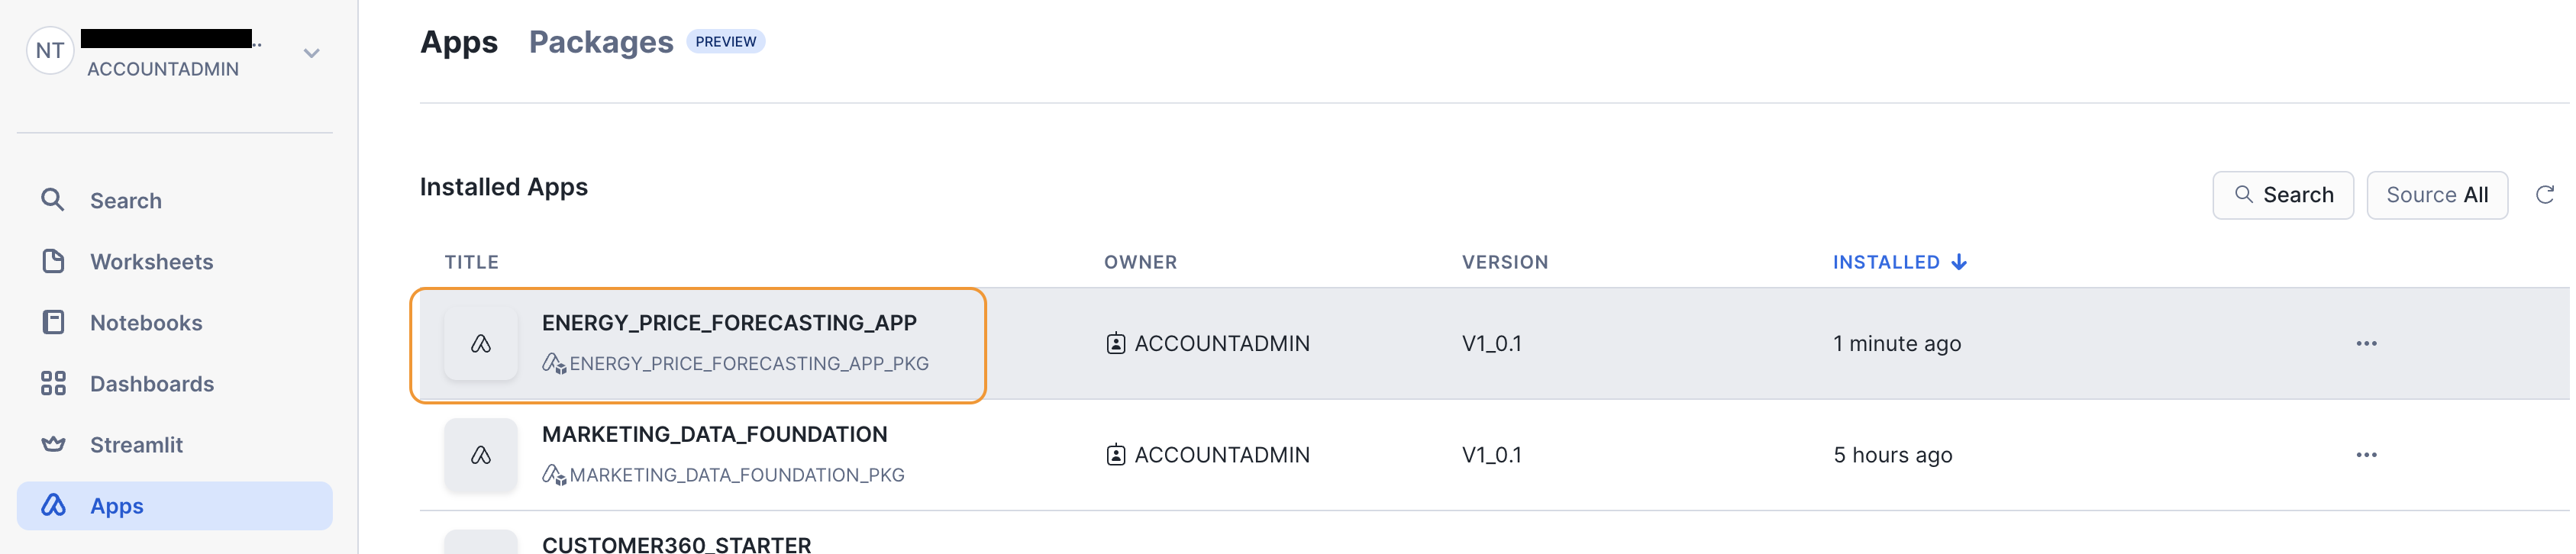